Training for a similarity model using triplet loss.

Babed on this tutorial: https://keras.io/examples/vision/siamese_network/

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path

2021-09-17 13:42:36.510791: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-17 13:42:36.510822: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet

In [3]:
import tensorflow

In [4]:
tensorflow.__version__

'2.6.0'

In [5]:
# target_shape = (28, 28)
target_shape = (32,32)
# target_shape = (56, 56)

In [6]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

def visualize(anchor, positive, negative, num_samples=3):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 3*num_samples))

    axs = fig.subplots(num_samples,3)
    for i in range(num_samples):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

In [7]:
image_folder = '/mnt/osn3/caceres/classes/geological/geological_similarity'

classes = [ 'andesite', 'gneiss', 'marble', 'quartzite', 'rhyolite', 'schist']

In [8]:
import glob

In [9]:
filenames = {}
for i, label in enumerate(classes):
    image_list = glob.glob(image_folder + '/' + label + '/*.jpg')
    filenames[i] = []
    for filename in image_list:
        filenames[i].append(filename)

In [10]:
[len(v) for k,v in filenames.items()]

[5000, 5000, 4998, 5000, 5000, 5000]

In [11]:
test_perc = 0.2

train_set = []
test_set = []
for k,v in filenames.items():
    random.shuffle(v)
    test_count = int(test_perc * len(v))
    test_set.extend(v[:test_count])
    train_set.extend(v[test_count:])

In [12]:
len(train_set), len(test_set)

(23999, 5999)

# Prepare data

In [13]:
def train_gen(image_list, batch_size=32):
    """Online data generator. Yields batches of anchors, positive, and negatives samples for triplet based training. 

    Args:
        image_list (list]): List of training samples available. 
        batch_size (int, optional): Batch size. Defaults to 32.

    Yields:
        list: List of anchors, positive, and negative samples.
    """
    
    while True:
        # choose random sample for batch
        anchors = random.sample(image_list, batch_size)
        #print(anchors)
        positives = []
        negatives = []
        # get positive and negative
        #c = 0
        for anchor in anchors:
            #print(c)
            class_name, image_name = os.path.split(anchor)
            _, class_name = os.path.split(class_name)
    
            failed = True
            while failed:
                positive = random.choice(image_list)
                pos_class_name, pos_image_name = os.path.split(positive)
                _, pos_class_name = os.path.split(pos_class_name)
                #print('pos', class_name, image_name, pos_class_name, pos_image_name)
                if class_name == pos_class_name and image_name != pos_image_name:
                    failed = False
            positives.append(positive)
            
            failed = True
            while failed:
                negative = random.choice(image_list)
                neg_class_name, neg_image_name = os.path.split(negative)
                _, neg_class_name = os.path.split(neg_class_name)
                #print('neg', class_name, image_name, neg_class_name, neg_image_name)
                if class_name != neg_class_name:
                    failed = False
            negatives.append(negative)
            #c += 1
            
        tuple_triplets = [preprocess_triplets(anchor, pos, neg) for anchor, pos, neg in zip(anchors, positives, negatives)]

        anchors, positives, negatives = zip(*tuple_triplets)
        anchors = tensorflow.stack(anchors,0)
        positives = tensorflow.stack(positives,0)
        negatives = tensorflow.stack(negatives,0)
        
        dataset = [anchors, positives, negatives]
        
        #print('yielding')
        yield dataset

In [14]:
o = next(train_gen(test_set, 4))

2021-09-17 13:42:38.811400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-17 13:42:38.812281: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-17 13:42:38.812351: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-09-17 13:42:38.812413: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-09-17 13:42:38.814426: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

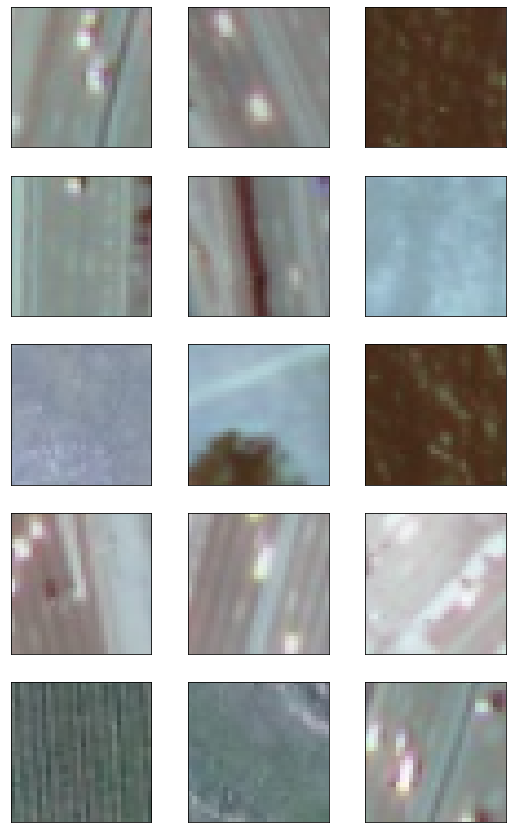

In [15]:
visualize(*list(next(train_gen(test_set, batch_size=8))),num_samples=5)

In [16]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [17]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [18]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        #print(type(inputs))
        #print([x.shape for x in inputs]) #, len(inputs), inputs.shape)
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [19]:
batch_size = 32
steps_per_epoch = len(train_set) // batch_size

validation_steps = len(test_set) // batch_size

steps_per_epoch,validation_steps

(749, 187)

In [20]:
siamese_model = SiameseModel(siamese_network, margin=0.5)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))

lr_steps_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

# siamese_model.fit(train_dataset, epochs=50, validation_data=val_dataset)

history = siamese_model.fit(train_gen(train_set, batch_size=batch_size), 
                  epochs=50, 
                  validation_data=train_gen(test_set, batch_size=batch_size),
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps, 
                  callbacks=[lr_steps_callback, es_callback])

# siamese_model.fit(input_fn(train_set, batch_size=32), 
#                   epochs=50, 
#                   validation_data=input_fn(test_set, batch_size=32))

2021-09-17 13:42:41.874830: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
749/749 [==============================] - 353s 464ms/step - loss: 0.2741 - val_loss: 0.1608
Epoch 2/50
749/749 [==============================] - 351s 469ms/step - loss: 0.1506 - val_loss: 0.1406
Epoch 3/50
749/749 [==============================] - 365s 487ms/step - loss: 0.1291 - val_loss: 0.1192
Epoch 4/50
749/749 [==============================] - 366s 489ms/step - loss: 0.1196 - val_loss: 0.1541
Epoch 5/50
749/749 [==============================] - 362s 484ms/step - loss: 0.1136 - val_loss: 0.1219
Epoch 6/50
749/749 [==============================] - 344s 459ms/step - loss: 0.1025 - val_loss: 0.1049
Epoch 7/50
749/749 [==============================] - 355s 475ms/step - loss: 0.1005 - val_loss: 0.0979
Epoch 8/50
749/749 [==============================] - 359s 480ms/step - loss: 0.0980 - val_loss: 0.0947
Epoch 9/50
749/749 [==============================] - 365s 487ms/step - loss: 0.0959 - val_loss: 0.0979
Epoch 10/50
749/749 [==============================] - 351s 469m

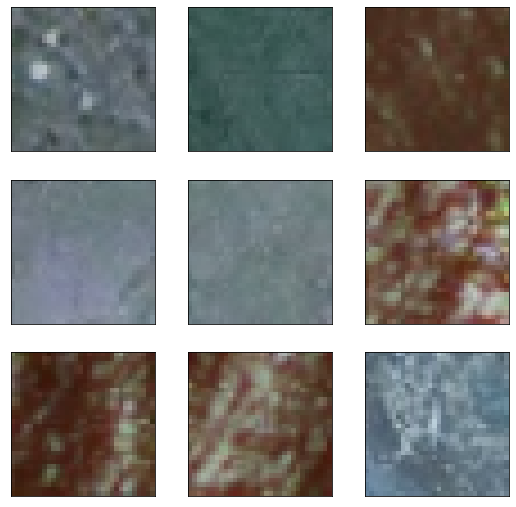

In [21]:
# sample = next(iter(train_dataset))
sample = next(train_gen(train_set, batch_size=batch_size))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

In [22]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

# Positive similarity: 0.99999315
# Negative similarity 0.9999791

Positive similarity: 0.9999938
Negative similarity 0.9999782


# Save model

In [23]:
save_model = False
if save_model:
    save_path = '/home/ccaceresgarcia/Documents/Projects/image_search/ImageSearch/tripletExtractor/'
    tensorflow.saved_model.save(embedding, save_path)
    embedding.save('TripletResnet50_v1.h5')

# Get similar images

In [82]:
def extract_features(filename, doaug=True):
    """Extract features from an image file using the embedding network previously trained.

    Args:
        filename (str): Path to imgae file.
        doaug (bool, optional): Flag to get the average embedding from multiple image rotations. Defaults to True.

    Returns:
        list: List representation of the image embeddings.
    """
    img = preprocess_image(filename)
    img = tensorflow.expand_dims(img, 0)  
    
    if doaug:
        features = []
        for rot in range(4):
            img = tf.image.rot90(img)
            flat_feature = embedding(resnet.preprocess_input(img)).numpy().reshape(-1)
            features.append(flat_feature)

        feats = list(np.average(features, axis=0))
    else:
        feats = list(embedding(resnet.preprocess_input(img)).numpy().reshape(-1))

    return feats
    
def get_features(image_list, doaug=True):
    """Get features for a set.

    Args:
        image_list (list): List of images to extract embeddings for.

    Returns:
        list: List of embeddings
    """
    features = []
    for filename in image_list:
        feats = extract_features(filename, doaug=doaug)
        features.append(feats)

    return features

In [83]:
train_features = get_features(train_set)

## Write vectors to file for s3 upload

In [84]:
save_files = False
if save_files:

    import json
    import csv

    f3 = [str(list(x)) for x in features]
    with open("resnet_triplet_vectors.csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(f3)

    label_features = {}
    for i, label in enumerate(classes):
        label_features[i] = [(x, name) for name,x, la in zip(filenames, f3, labels) if la == label]

    print([len(x) for i, x in label_features.items()])

    ### Per Class files
    
    
    for i, label in enumerate(classes):
        f4, lab_names = zip(*label_features[i])

        feature_data = {'labels':label, 
                    'filenames':lab_names,
                    'features':f4}

        with open('resnet_triplet_vectors_{}.json'.format(label), 'w') as f:
            json.dump(feature_data, f)

    feature_data = {'labels':labels, 
                    'filenames':filenames,
                    'features':f3}

    with open('resnet_triplet_vectors.json', 'w') as f:
        json.dump(feature_data, f)

## Make KNN object

In [85]:
# for i, label in enumerate(classes):
#     image_list = glob.glob(image_folder + '/' + label + '/*.jpg')
#     print(i,label, len(image_list))
    
# len(labels), len(filenames), len(features)

In [86]:
from sklearn.neighbors import NearestNeighbors

In [87]:
neighbors = NearestNeighbors(n_neighbors=30, algorithm='brute',metric='euclidean').fit(train_features)

In [88]:
if save_files:
    import pickle 

    # Its important to use binary mode 
    knnPickle = open('knnpickle_file', 'wb') 

    # source, destination 
    pickle.dump(neighbors, knnPickle)                      

    # load the model from disk
    loaded_model = pickle.load(open('knnpickle_file.pickle', 'rb'))

    with open('filenames.pickle', 'wb') as f:
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(filenames, f, pickle.HIGHEST_PROTOCOL)

    with open('filenames.pickle', 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        loaded_filenames = pickle.load(f)

In [89]:
def get_class(x):
    """Get the class label for the given filepath

    Args:
        x (str): Filepath

    Returns:
        str: Class label
    """
    return os.path.split(os.path.split(x)[0])[1]

In [90]:
# boto3
# !pip3 install requests_aws4auth
# !pip3 install elasticsearch=='7.13.4' #https://opensearch.org/docs/clients/index/


In [91]:
from io import BytesIO
import base64
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random

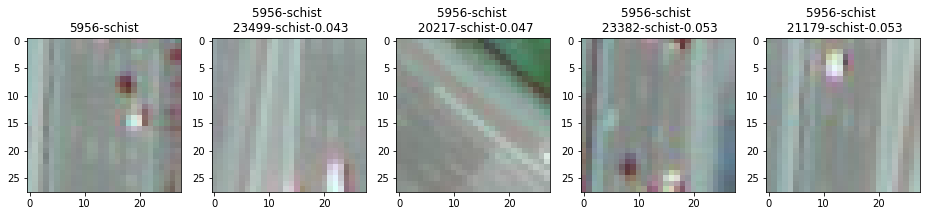

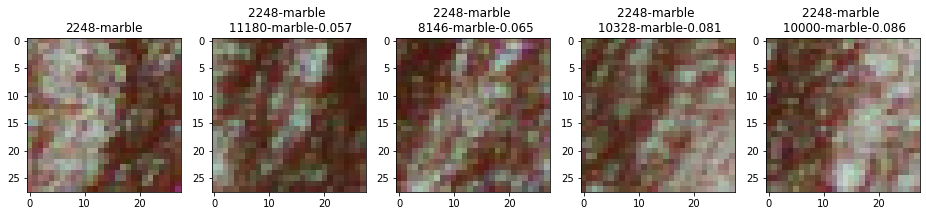

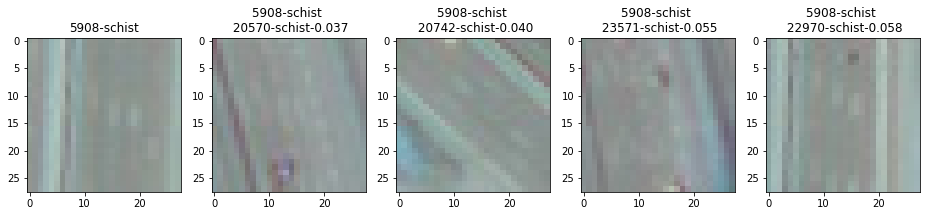

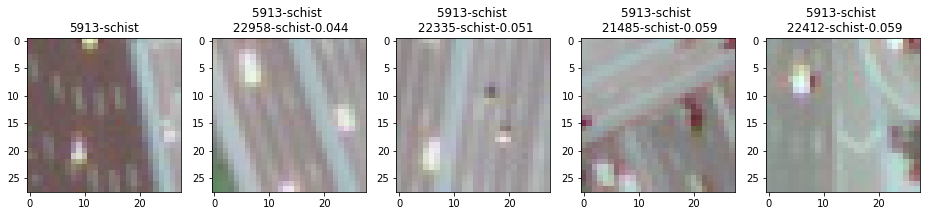

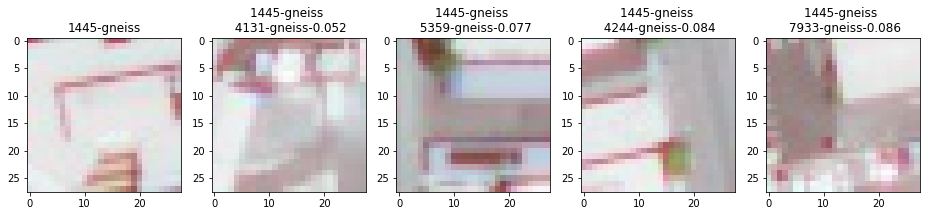

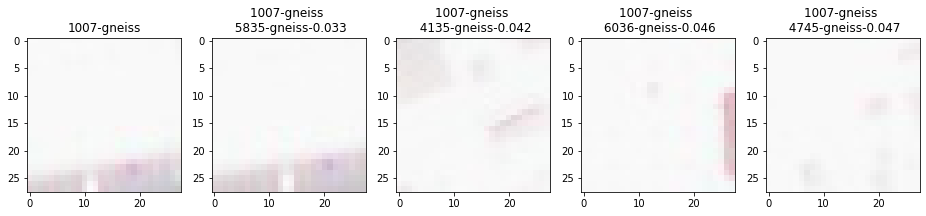

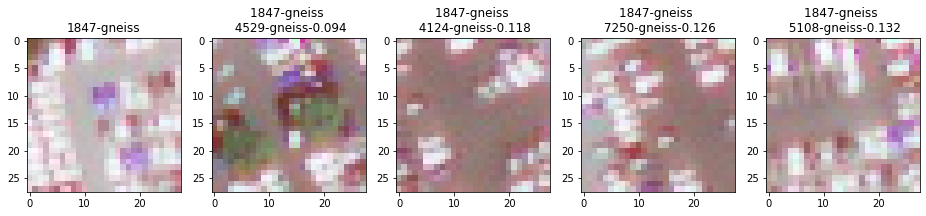

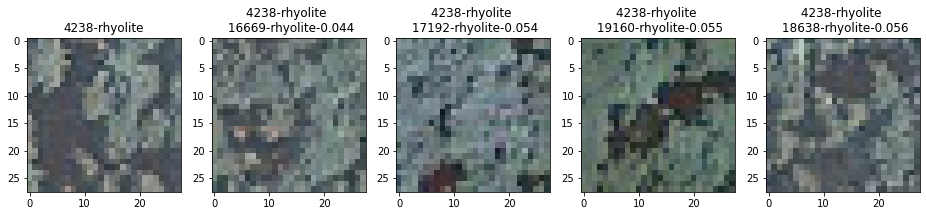

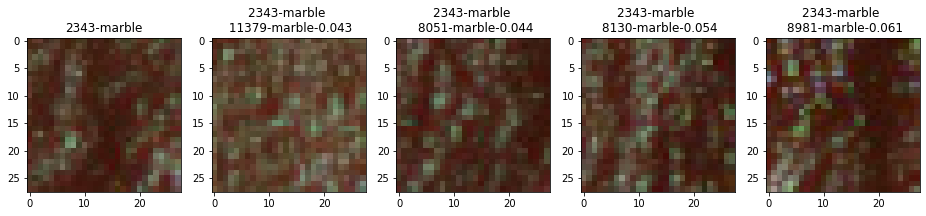

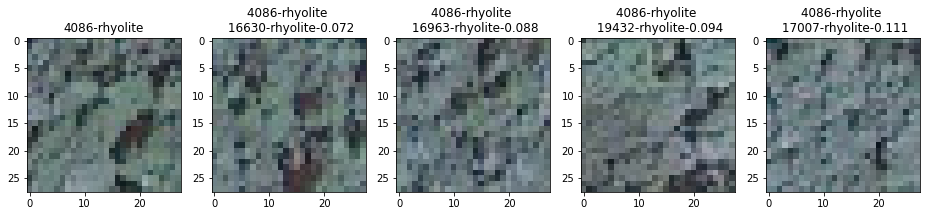

In [92]:
k = 4

for query in [random.randint(0,len(test_set)-1) for _ in range(10)]:
    
    test_file = test_set[query]
    flat_feature = extract_features(test_file)
    
    #print(flat_feature)
    im = np.asarray(Image.open(test_file))# convert image to numpy array
    
    distances, indices = neighbors.kneighbors([flat_feature])
    
    _, axes = plt.subplots(1,k+1,figsize=(16,4))
    axes.flat[0].imshow(im)
    axes.flat[0].set_title('{}-{}'.format(query, get_class(test_file)))

    for i in range(k):
        # load the image
        match = indices[0][i]
        train_file = train_set[match]
        image = Image.open(train_file)
        # convert image to numpy array
        im = np.asarray(image)
        axes.flat[i+1].imshow(im)
        axes.flat[i+1].set_title('{}-{} \n {}-{}-{:.3f}'.format(query, 
                                                              get_class(test_file), 
                                                              match, 
                                                              get_class(train_file), 
                                                              round(distances[0][i],3)))


In [101]:

def calculate_accuracy(model_func, train_set, test_set, k=5):
    """Calculate accuracy for method 2.

    Args:
        model_func (function): Function used to get image embeddings.
        test_set (list): list of test images.
        train_set (list): List of training images.
        k (int, optional): Number of similar images to get. Defaults to 5.

    Returns:
        [type]: [description]
    """

    correct = np.zeros((len(test_set), k))
    for i in range(len(test_set)):

        flat_feature = model_func(test_set[i])
        distances, indices = neighbors.kneighbors([flat_feature])
        #print(len(indices[0]))
        indices = indices[0]
        
        test_class = get_class(test_set[i])
        for j in range(k):
            similar_file = train_set[indices[j]]
            correct[i][j] = int(get_class(similar_file) == test_class)

    return correct

In [102]:
import time

In [109]:
len(test_set)

5999

In [103]:
ts = time.time()
acc = calculate_accuracy(extract_features, train_set, test_set, 10) 
print('took: ', time.time() - ts)

# margin = 10, took: 599.701
# [0.898,0.890,0.89,0.888,0.888,0.896,0.892,0.882, 0.893, 0.89]

# margin = 0.5, took:  572.965
# [0.911,0.906,0.906,0.9,0.902,0.906,0.903,0.9, 0.904,0.905]

# margin=0.5, rotation augmentation, took:  1356.685631275177
# [0.9357,0.935,0.932,0.931,0.9283,0.928,0.926,0.9275,0.928, 0.924]

took:  1356.685631275177


In [104]:
acc.shape

(5999, 10)

In [105]:
ksum = acc.sum(0)/acc.shape[0]

In [106]:
ksum.shape

(10,)

In [107]:
for k in range(len(ksum)):
    print(k+1, '=', ksum[k])

1 = 0.9356559426571095
2 = 0.9348224704117353
3 = 0.9324887481246874
4 = 0.9309884980830139
5 = 0.9283213868978163
6 = 0.9278213035505918
7 = 0.9256542757126188
8 = 0.9274879146524421
9 = 0.9281546924487415
10 = 0.9239873312218703


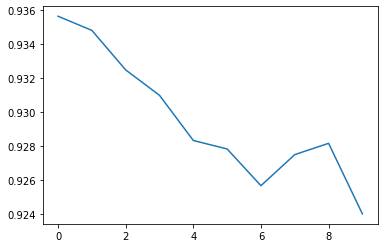

In [108]:
plt.plot(ksum)